# KODEX은행지수 예측 모델

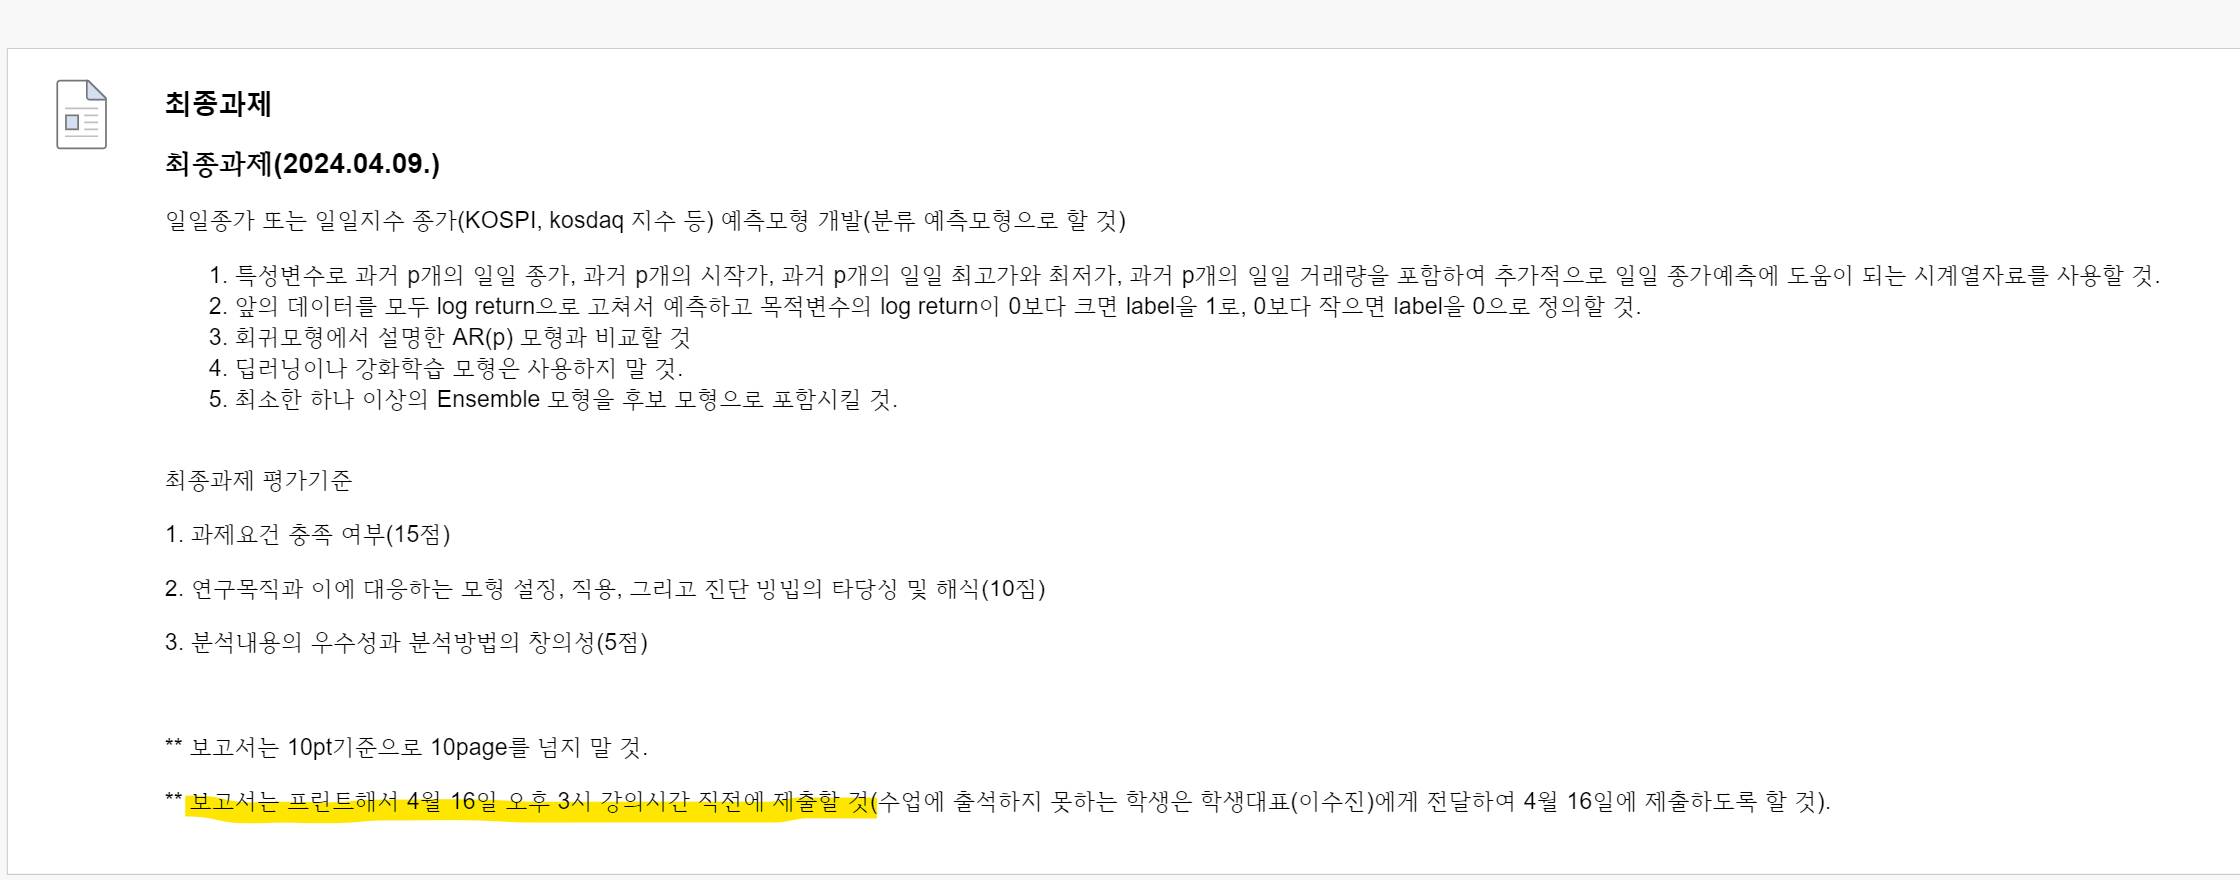

내가 이해한거는 목적변수 (종가든 시작가든 상관없댔음)를 전날 대비 올랐는지 log return(즉 수익률) 파생변수를 하나만들고, 이거가 전날보다 올랐으면 (0보다크면)1 이고, 전날보다 내려갔으면(0보다작으면) 0 으로 레이블링하라는 거같오 ,근데 전날에 데이터가 없다면 그전전날 데이터로 끌어오는 코드도 고려해라 요런식..

# KODEX 은행 데이터 불러오기

In [1]:
!pip install pykrx

In [2]:
from pykrx import stock
from pykrx import bond

In [3]:
from pykrx import stock
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd

#The line `tickers = stock.get_etf_ticker_list("20201119")` is calling a function `get_etf_ticker_list` from the `stock` module in the `pykrx` library. This function is used to retrieve a list of ETF tickers that were valid on the specified date "20201119". The function returns the list of ETF tickers, which is then converted into a DataFrame with a column named '종목코드'.
tickers = stock.get_etf_ticker_list("20201119")
tickers=pd.DataFrame(tickers,columns=['종목코드'])

url = 'https://finance.naver.com/api/sise/etfItemList.nhn'
json_data = json.loads(requests.get(url).text)
df = json_normalize(json_data['result']['etfItemList'])
df=df[['itemcode','itemname']]
df=df.rename(columns={"itemcode": "종목코드", "itemname": "종목명"})

etf=pd.merge(left=tickers,right=df,how='left',on='종목코드' )
bank_etf=etf[etf['종목명'].str.contains('은행')][1:]

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\1397452333.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = json_normalize(json_data['result']['etfItemList'])


In [4]:
bank_etf

,종목코드,종목명
272,091170,KODEX 은행


In [5]:
# KODEX 은행 기간 설정 #"20131227"부터 "20240412"까지로 설정 #실제로는 20140101~20240412까지할거임
df_kodex = stock.get_etf_ohlcv_by_date("20131227", "20240412", '091170')
print(df_kodex.head())

                NAV    시가    고가    저가    종가     거래량        거래대금    기초지수
날짜                                                                     
2013-12-27  8359.52  8280  8335  8240  8335    6021    50096690  836.79
2013-12-30  8526.02  8335  8540  8335  8540   26560   225016795  853.67
2014-01-02  8486.64  8595  8680  8410  8490  118777  1014985790  849.67
2014-01-03  8225.64  8425  8435  8220  8235   16046   132756530  823.30
2014-01-06  8239.39  8255  8325  8160  8235    5639    46433115  824.71


In [6]:
df_kodex.tail() # KODEX 데이터

#시가	고가	저가	종가	거래량	4개만 필요할듯

,NAV,시가,고가,저가,종가,거래량,거래대금,기초지수
날짜,,,,,,,,
2024-04-05,7982.42,7950,8075,7935,7985,393780,3159634290,777.91
2024-04-08,8064.02,8000,8130,7980,8055,748528,6039808695,786.36
2024-04-09,7996.32,8085,8140,7985,8030,423717,3406776395,779.38
2024-04-11,7935.16,7635,7985,7625,7920,1055072,8268238985,773.08
2024-04-12,7674.79,7870,7905,7640,7660,1138940,8777506815,746.13


## log return 만들기
log return 과 return의 차이비교필요

### return 값 생성

In [57]:
df_kodex_close= (df_kodex['종가']/df_kodex['종가'].shift(1)-1)*100 #위 수식 코드로 구현

df_kodex_close #전날 대비 수익률

#return으로 변경하고 merge하기

날짜
2013-12-27         NaN
2013-12-30    2.459508
2014-01-02   -0.585480
2014-01-03   -3.003534
2014-01-06    0.000000
                ...   
2024-04-05   -0.930521
2024-04-08    0.876644
2024-04-09   -0.310366
2024-04-11   -1.369863
2024-04-12   -3.282828
Name: 종가, Length: 2531, dtype: float64

In [58]:
df_kodex = df_kodex[['시가','고가','저가','종가','거래량']]
df_kodex

,시가,고가,저가,종가,거래량
날짜,,,,,
2013-12-27,8280,8335,8240,8335,6021
2013-12-30,8335,8540,8335,8540,26560
2014-01-02,8595,8680,8410,8490,118777
2014-01-03,8425,8435,8220,8235,16046
2014-01-06,8255,8325,8160,8235,5639
...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780
2024-04-08,8000,8130,7980,8055,748528
2024-04-09,8085,8140,7985,8030,423717


In [59]:
df_kodex.copy()

,시가,고가,저가,종가,거래량
날짜,,,,,
2013-12-27,8280,8335,8240,8335,6021
2013-12-30,8335,8540,8335,8540,26560
2014-01-02,8595,8680,8410,8490,118777
2014-01-03,8425,8435,8220,8235,16046
2014-01-06,8255,8325,8160,8235,5639
...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780
2024-04-08,8000,8130,7980,8055,748528
2024-04-09,8085,8140,7985,8030,423717


In [82]:
# Merge df_kodex and df_kodex_close on '날짜'
merged_df = df_kodex.merge(df_kodex_close, left_index=True, right_index=True, how='left')
merged_df

,시가,고가,저가,종가_x,거래량,종가_y
날짜,,,,,,
2013-12-27,8280,8335,8240,8335,6021,NaN
2013-12-30,8335,8540,8335,8540,26560,2.459508
2014-01-02,8595,8680,8410,8490,118777,-0.585480
2014-01-03,8425,8435,8220,8235,16046,-3.003534
2014-01-06,8255,8325,8160,8235,5639,0.000000
...,...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780,-0.930521
2024-04-08,8000,8130,7980,8055,748528,0.876644
2024-04-09,8085,8140,7985,8030,423717,-0.310366


In [ ]:
# 데이터프레임 merged_df의 모든 컬럼을 float으로 변환
for column in merged_df.columns:
    merged_df[column] = merged_df[column].astype(float)

In [83]:
#칼럼명 변경
merged_df.rename(columns={'종가_x': '종가','종가_y':'return'}, inplace=True)
merged_df

,시가,고가,저가,종가,거래량,return
날짜,,,,,,
2013-12-27,8280,8335,8240,8335,6021,NaN
2013-12-30,8335,8540,8335,8540,26560,2.459508
2014-01-02,8595,8680,8410,8490,118777,-0.585480
2014-01-03,8425,8435,8220,8235,16046,-3.003534
2014-01-06,8255,8325,8160,8235,5639,0.000000
...,...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780,-0.930521
2024-04-08,8000,8130,7980,8055,748528,0.876644
2024-04-09,8085,8140,7985,8030,423717,-0.310366


### log_return (로그 변동률) 생성
merged_df['return'] + 1이 0이 되면, np.log(0)은 정의되지 않아 NaN이 됩니다.->이거는 수익률구할때

In [89]:
import numpy as np
df_kodex_close_log= np.log(df_kodex['종가']/df_kodex['종가'].shift(1)) #위 수식 코드로 구현

df_kodex_close_log #전날 대비 수익률 log

# shift(1) 함수는 각 가격을 하나씩 위로 이동시켜, 각 시점의 가격과 바로 이전 시점의 가격을 비교할 수 있게 합니다.
#log_return으로 변경하고 merge하기

날짜
2013-12-27         NaN
2013-12-30    0.024297
2014-01-02   -0.005872
2014-01-03   -0.030496
2014-01-06    0.000000
                ...   
2024-04-05   -0.009349
2024-04-08    0.008728
2024-04-09   -0.003108
2024-04-11   -0.013793
2024-04-12   -0.033379
Name: 종가, Length: 2531, dtype: float64

In [90]:
# Merge df_kodex and df_kodex_close on '날짜'
merged_df = merged_df.merge(df_kodex_close_log, left_index=True, right_index=True, how='left')
merged_df

,시가,고가,저가,종가_x,거래량,종가_y
날짜,,,,,,
2013-12-27,8280,8335,8240,8335,6021,NaN
2013-12-30,8335,8540,8335,8540,26560,0.024297
2014-01-02,8595,8680,8410,8490,118777,-0.005872
2014-01-03,8425,8435,8220,8235,16046,-0.030496
2014-01-06,8255,8325,8160,8235,5639,0.000000
...,...,...,...,...,...,...
2024-04-05,7950,8075,7935,7985,393780,-0.009349
2024-04-08,8000,8130,7980,8055,748528,0.008728
2024-04-09,8085,8140,7985,8030,423717,-0.003108


In [94]:
merged_df.rename(columns={'종가_x': '종가','종가_y':'log_return'}, inplace=True)

In [95]:
merged_df.head()

,시가,고가,저가,종가,거래량,log_return
날짜,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000


In [93]:
merged_df.dtypes

시가      float64
고가      float64
저가      float64
종가_x    float64
거래량     float64
종가_y    float64
dtype: object

In [96]:
merged_df.head(30)

,시가,고가,저가,종가,거래량,log_return
날짜,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280
2014-01-09,8180.0,8340.0,8180.0,8290.0,7646.0,0.011526
2014-01-10,8225.0,8270.0,8085.0,8090.0,11189.0,-0.024421


### 목적변수 target 컬럼 생성

In [97]:
merged_df['target'] = (merged_df['log_return'] > 0).astype(int)

merged_df

,시가,고가,저가,종가,거래량,log_return,target
날짜,,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN,0
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297,1
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0
...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0


### 이거는 fdr로 불러올때...

In [14]:
# df_index_list = fdr.SnapDataReader('KRX/INDEX/LIST') # KRX 전체 지수목록
# df_index_list

# 데이터 시각화

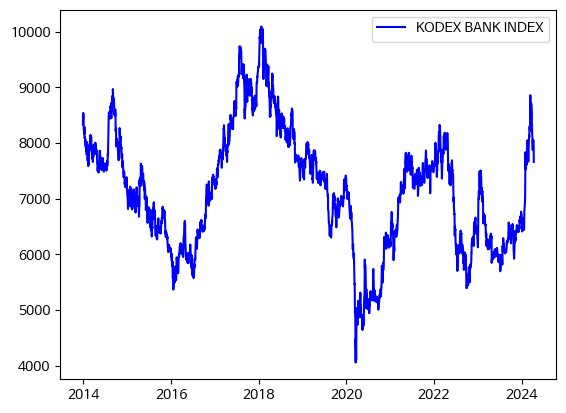

In [100]:
import matplotlib.pyplot as plt
plt.plot(merged_df.index,merged_df.종가,'b',label='KODEX BANK INDEX')
plt.legend(loc='best')
plt.show()

#코로나로 인해 2020년에 은행 index에 극심한 변화가 있었음을 알 수 있음

# 파생변수
- cofix
- 환율
- 국내금리
- 기준금리

## 1. 코픽스 변수 데이터 불러오기
- 변수선택이유: 신규취급액의 경우 한 달 동안의 금리를 평균으로 산출하기 때문에 시장금리에 민감하게 반응합니다. 상승도 하강도 거의 즉각 반응한다고 보셔도 무리가 없습니다.  
  -> 같은 논리로 단기 cofix는 주간의 금리를 평균으로 산출

In [16]:
# import requests
# year = 2013
# url = f'https://portal.kfb.or.kr/fingoods/cofix.php?BasicYear_W={year}&BasicYear={year}'
# headers = {
#     'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
#     'Accept-Encoding': 'gzip, deflate, br',
#     'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
#     'Host': 'portal.kfb.or.kr',
#     'Referer': 'https://portal.kfb.or.kr/fingoods/cofix.php?BasicYear_W=&BasicYear=2022',
#     'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Whale/3.21.192.22 Safari/537.36',
# }
# res = requests.get(url, headers=headers)
# res.encoding = 'euc-kr'
# res.text

In [17]:
# import pandas as pd
# df_cofix = pd.read_html(res.text)
# df_cofix

In [18]:
import requests
import pandas as pd

def get_cofix_tables(year):
    url = f'https://portal.kfb.or.kr/fingoods/cofix.php?BasicYear_W={year}&BasicYear={year}'
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7',
        'Host': 'portal.kfb.or.kr',
        'Referer': 'https://portal.kfb.or.kr/fingoods/cofix.php?BasicYear_W=&BasicYear=2024',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Whale/3.21.192.22 Safari/537.36',
    }
    res = requests.get(url, headers=headers)
    res.encoding = 'euc-kr'
    return pd.read_html(res.text)

df_cofix = pd.DataFrame() 
df_cofix_short = pd.DataFrame()

for year in range(2013, 2025):
    dfs = get_cofix_tables(year)
    df_cofix = pd.concat([df_cofix, dfs[0]])
    df_cofix_short = pd.concat([df_cofix_short, dfs[1]])

## COFIX 변수 전처리.. (단기로 해야되나...?신규취급액이 나으려나,두개다해보기)
 1) 신규취급액기준 COFIX : 
 2)  단기코픽스 : CD를 대체해서 단기대출 지표금리로 쓰기 위해 만든 금리다. 시중은행 만기 3개월짜리 단기 조달 상품들의 최근 1주간 신규취급액에 대해 가중 평균한 지수다. 기존 코픽스와 달리 계약만기 3개월물인 단기자금만을 대상으로 한다.

### 1-1) 신규취급액기준 COFIX 전처리 및 컬럼 생성

In [19]:
df_cofix #대상월로 적용

,공시일,대상월,신규취급액기준 COFIX,잔액기준 COFIX,신 잔액기준 COFIX
0,2013/12/16,2013/11,2.60,2.91,NaN
1,2013/11/15,2013/10,2.62,2.94,NaN
2,2013/10/15,2013/09,2.63,2.99,NaN
3,2013/09/16,2013/08,2.62,3.02,NaN
4,2013/08/16,2013/07,2.63,3.06,NaN
...,...,...,...,...,...
10,2023/02/15,2023/01,3.82,3.63,3.02
11,2023/01/16,2022/12,4.29,3.52,2.92
0,2024/03/15,2024/02,3.62,3.81,3.24
1,2024/02/15,2024/01,3.66,3.84,3.29


In [ ]:
# if merged_df['날짜',mm] = df_cofix mm  :
#     left_index=True, right_index=True, how='left')

In [29]:
df_cofix = df_cofix[['대상월','신규취급액기준 COFIX']]
df_cofix

,대상월,신규취급액기준 COFIX
0,2013/11,2.60
1,2013/10,2.62
2,2013/09,2.63
3,2013/08,2.62
4,2013/07,2.63
...,...,...
10,2023/01,3.82
11,2022/12,4.29
0,2024/02,3.62
1,2024/01,3.66


In [ ]:
# 대상월 포맷 변경
df_cofix = pd.to_datetime(df_cofix['대상월'], format='%Y/%m').dt.to_period('M') #m을로 데이터ㅏ뽑기

# 데이터프레임을 '대상월'로 정렬 후 인덱스 재설정
df_cofix = df_cofix.sort_values('대상월').reset_index(drop=True)

df_cofix

In [39]:
df_cofix

,대상월,신규취급액기준 COFIX
0,2013-11,2.60
1,2013-10,2.62
2,2013-09,2.63
3,2013-08,2.62
4,2013-07,2.63
...,...,...
10,2023-01,3.82
11,2022-12,4.29
0,2024-02,3.62
1,2024-01,3.66


In [262]:
df_cofix.to_csv('cofix.csv')

### 1-2) 단기 COFIX 전처리 및 컬럼생성

In [20]:
df_cofix_short.tail(30)
#대상기간에 적용

,공시일,대상기간,단기 COFIX
37,2023/04/12,2023/04/01 ~ 2023/04/07,3.47
38,2023/04/05,2023/03/25 ~ 2023/03/31,3.49
39,2023/03/29,2023/03/18 ~ 2023/03/24,3.48
40,2023/03/22,2023/03/11 ~ 2023/03/17,3.56
41,2023/03/15,2023/03/04 ~ 2023/03/10,3.55
42,2023/03/08,2023/02/25 ~ 2023/03/03,3.49
43,2023/03/02,2023/02/18 ~ 2023/02/24,3.55
44,2023/02/22,2023/02/11 ~ 2023/02/17,3.38
45,2023/02/15,2023/02/04 ~ 2023/02/10,3.44
46,2023/02/08,2023/01/28 ~ 2023/02/03,3.53


In [23]:
# 날짜 범위 생성 및 적용
df_cofix_short.copy()

date_range = []
for _, row in df_cofix_short.iterrows():
    start_date, end_date = row['대상기간'].split(' ~ ')
    dates = pd.date_range(start=start_date, end=end_date)
    date_range.extend([(date, row['단기 COFIX']) for date in dates])

# 새로운 데이터프레임 생성
df_cofix_short = pd.DataFrame(date_range, columns=['날짜', '단기 COFIX'])
df_cofix_short.sort_values(by='날짜', ascending=False, inplace=True)
df_cofix_short.reset_index(drop=True, inplace=True)

df_cofix_short

,날짜,단기 COFIX
0,2024-04-05,3.57
1,2024-04-04,3.57
2,2024-04-03,3.57
3,2024-04-02,3.57
4,2024-04-01,3.57
...,...,...
4095,2012-12-26,2.95
4096,2012-12-25,2.95
4097,2012-12-24,2.95
4098,2012-12-23,2.95


In [ ]:
df_cofix_short.set_index('날짜', inplace=True)

In [28]:
df_cofix_short.head(30)

,단기 COFIX
날짜,
2024-04-05,3.57
2024-04-04,3.57
2024-04-03,3.57
2024-04-02,3.57
2024-04-01,3.57
2024-03-31,3.57
2024-03-30,3.57
2024-03-29,3.60
2024-03-28,3.60


In [263]:
df_cofix_short.to_csv('cofix_short.csv')

In [ ]:
# # Create a new DataFrame based on df1
# merged_df = merged_df.copy()
# merged_df['cofix_short'] = None  # Initialize the 단기 COFIX column

# # Function to find the 단기 COFIX value for each date in df1
# def find_cofix(date, df_cofix_short):
#     # Reverse iteration to find the first applicable 단기 COFIX value before the date
#     for idx in range(len(df_cofix_short) - 1, -1, -1):
#         if df_cofix_short.iloc[idx]['공시일'] <= date:
#             return df_cofix_short.iloc[idx]['단기 COFIX']
#     return None

# # Applying the function to populate the 단기 COFIX column in merged_df
# merged_df['cofix_short'] = merged_df.index.map(lambda x: find_cofix(x, df_cofix_short))

# merged_df

In [ ]:
# merged_df.head(30)

## 2. 환율 변수 
### 전처리 및 환율 컬럼생성

In [40]:
# Load the Excel file
df_change = pd.read_excel('C:/Users/chanyoung/Downloads/주요국 통화의 대원화 환율.xlsx')
df_change

,주요국 통화의 대원화 환율,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,주석,"1) 원/달러, 원/위안은 서울외국환시장 은행간 거래의 종가 기준2) 원/엔(하나은...",NaN,NaN
1,출처,ECOS,NaN,NaN
2,범례명,원/달러(좌축),원/100엔(좌축),원/위안(우축)
3,단위,(원),(원),(원)
4,주기,일,일,일
...,...,...,...,...
8439,2024-04-05,1352.8,894.5,186.7
8440,2024-04-08,1353.2,891.29,186.81
8441,2024-04-09,1354.9,892.06,187.06
8442,2024-04-11,1364.1,891.13,188.04


In [41]:
df_change.head(10)

,주요국 통화의 대원화 환율,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,주석,"1) 원/달러, 원/위안은 서울외국환시장 은행간 거래의 종가 기준2) 원/엔(하나은...",NaN,NaN
1,출처,ECOS,NaN,NaN
2,범례명,원/달러(좌축),원/100엔(좌축),원/위안(우축)
3,단위,(원),(원),(원)
4,주기,일,일,일
5,기간,1990-03-02 ~ 2024-04-12,2005-03-02 ~ 2024-04-12,2014-12-01 ~ 2024-04-12
6,1990-03-02,693,NaN,NaN
7,1990-03-05,695.1,NaN,NaN
8,1990-03-06,696.4,NaN,NaN
9,1990-03-07,697.6,NaN,NaN


In [42]:
df_change= df_change[6:]
df_change

,주요국 통화의 대원화 환율,Unnamed: 1,Unnamed: 2,Unnamed: 3
6,1990-03-02,693,NaN,NaN
7,1990-03-05,695.1,NaN,NaN
8,1990-03-06,696.4,NaN,NaN
9,1990-03-07,697.6,NaN,NaN
10,1990-03-08,698.1,NaN,NaN
...,...,...,...,...
8439,2024-04-05,1352.8,894.5,186.7
8440,2024-04-08,1353.2,891.29,186.81
8441,2024-04-09,1354.9,892.06,187.06
8442,2024-04-11,1364.1,891.13,188.04


In [43]:
df_change.rename(columns={'주요국 통화의 대원화 환율': 'Date'}, inplace=True)

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\3889438914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change.rename(columns={'주요국 통화의 대원화 환율': 'Date'}, inplace=True)


In [44]:
df_change.rename(columns={'Unnamed: 1': '환율'}, inplace=True)
df_change

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\311575333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change.rename(columns={'Unnamed: 1': '환율'}, inplace=True)


,Date,환율,Unnamed: 2,Unnamed: 3
6,1990-03-02,693,NaN,NaN
7,1990-03-05,695.1,NaN,NaN
8,1990-03-06,696.4,NaN,NaN
9,1990-03-07,697.6,NaN,NaN
10,1990-03-08,698.1,NaN,NaN
...,...,...,...,...
8439,2024-04-05,1352.8,894.5,186.7
8440,2024-04-08,1353.2,891.29,186.81
8441,2024-04-09,1354.9,892.06,187.06
8442,2024-04-11,1364.1,891.13,188.04


In [46]:
df_change = df_change[['Date','환율']]

In [48]:
df_change

<bound method NDFrame.describe of             Date      환율
6     1990-03-02     693
7     1990-03-05   695.1
8     1990-03-06   696.4
9     1990-03-07   697.6
10    1990-03-08   698.1
...          ...     ...
8439  2024-04-05  1352.8
8440  2024-04-08  1353.2
8441  2024-04-09  1354.9
8442  2024-04-11  1364.1
8443  2024-04-12  1375.4

[8438 rows x 2 columns]>

In [50]:
df_change.reindex(index=['Date'])
df_change

,Date,환율
6,1990-03-02,693
7,1990-03-05,695.1
8,1990-03-06,696.4
9,1990-03-07,697.6
10,1990-03-08,698.1
...,...,...
8439,2024-04-05,1352.8
8440,2024-04-08,1353.2
8441,2024-04-09,1354.9
8442,2024-04-11,1364.1


In [53]:
# 데이터프레임의 각 컬럼 데이터 타입 확인
df_change.dtypes #object 였음

Date    object
환율      object
dtype: object

In [54]:
# Date 칼럼을 datetime 형식으로 변환
df_change['Date'] = pd.to_datetime(df_change['Date'])
# Date 칼럼을 인덱스로 설정하고 데이터를 Date 순으로 정렬
df_change.set_index('Date', inplace=True)
df_change.sort_index(inplace=True)

df_change

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\1931714846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_change['Date'] = pd.to_datetime(df_change['Date'])


,환율
Date,
1990-03-02,693
1990-03-05,695.1
1990-03-06,696.4
1990-03-07,697.6
1990-03-08,698.1
...,...
2024-04-05,1352.8
2024-04-08,1353.2
2024-04-09,1354.9


In [ ]:
# 환율 컬럼을 float 타입으로 변환
df_change['환율'] = df_change['환율'].astype(float)

# 특정 날짜 범위로 데이터를 자르기
df_change = df_change.loc['2013-12-27':'2024-04-12']

In [56]:
df_change

,환율
Date,
2013-12-27,1053.9
2013-12-30,1055.4
2014-01-02,1050.3
2014-01-03,1055.2
2014-01-06,1065.4
...,...
2024-04-05,1352.8
2024-04-08,1353.2
2024-04-09,1354.9


In [264]:
df_change.to_csv('exchange.csv')

## 3. 한국은행기준금리 데이터
- 한국은행 경제 통계시스템 2013~20240411


In [ ]:
# df = df.transpose()	#행 열 전환
# df.rename(columns=df.iloc[0], inplace=True)	# 행열이 전환된 데이터프레임의 열 이름 제대로 수정
# df = df.drop(df.index[0])

In [149]:
df_base = pd.read_csv("C:/Users/chanyoung/Downloads/한국은행 기준금리 및 여수신금리_14090757.csv",encoding='utf-8')
df_base = df_base.transpose()	#행 열 전환
df_base

,0
통계표,1.3.1. 한국은행 기준금리 및 여수신금리
계정항목,한국은행 기준금리
단위,연%
변환,원자료
2013/01/01,2.75
...,...
2024/04/07,3.5
2024/04/08,3.5
2024/04/09,3.5
2024/04/10,3.5


In [150]:
df_base.rename(columns=df_base.iloc[1],inplace=True)
df_base

,한국은행 기준금리
통계표,1.3.1. 한국은행 기준금리 및 여수신금리
계정항목,한국은행 기준금리
단위,연%
2013/01/01,2.75
2013/01/02,2.75
...,...
2024/04/07,3.5
2024/04/08,3.5
2024/04/09,3.5
2024/04/10,3.5


In [152]:
df_base = df_base.iloc[3:]
df_base

,한국은행 기준금리
2013/01/01,2.75
2013/01/02,2.75
2013/01/03,2.75
2013/01/04,2.75
2013/01/05,2.75
...,...
2024/04/07,3.5
2024/04/08,3.5
2024/04/09,3.5
2024/04/10,3.5


In [157]:
# 인덱스를 날짜 형식으로 변환
df_base.index = pd.to_datetime(df_base.index)
df_base

,한국은행 기준금리
날짜,
2013-01-01,2.75
2013-01-02,2.75
2013-01-03,2.75
2013-01-04,2.75
2013-01-05,2.75
...,...
2024-04-07,3.5
2024-04-08,3.5
2024-04-09,3.5


In [254]:
df_base = df_base.rename_axis('Date')
df_base

,한국은행 기준금리
Date,
2013-01-01,2.75
2013-01-02,2.75
2013-01-03,2.75
2013-01-04,2.75
2013-01-05,2.75
...,...
2024-04-07,3.5
2024-04-08,3.5
2024-04-09,3.5


In [265]:
df_base.to_csv('base.csv')

In [102]:
merged_df.copy()

,시가,고가,저가,종가,거래량,log_return,target
날짜,,,,,,,
2013-12-27,8280.0,8335.0,8240.0,8335.0,6021.0,NaN,0
2013-12-30,8335.0,8540.0,8335.0,8540.0,26560.0,0.024297,1
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0
...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0


In [103]:
# 2014-01-01부터 시작하도록 데이터 필터링
merged_df = merged_df[merged_df.index >= '2014-01-01']

# 데이터 확인
merged_df.head(), merged_df.shape

(                시가      고가      저가      종가       거래량  log_return  target
 날짜                                                                      
 2014-01-02  8595.0  8680.0  8410.0  8490.0  118777.0   -0.005872       0
 2014-01-03  8425.0  8435.0  8220.0  8235.0   16046.0   -0.030496       0
 2014-01-06  8255.0  8325.0  8160.0  8235.0    5639.0    0.000000       0
 2014-01-07  8200.0  8260.0  8160.0  8160.0   11565.0   -0.009149       0
 2014-01-08  8190.0  8260.0  8135.0  8195.0    7145.0    0.004280       1,
 (2529, 7))

### 데이터 전처리 & 원본시계열, 이동평균, 이동표준편차 시각화

In [178]:
# 거래량이 0인 일자 제거 & 수정종가 데이터만 사용
data = merged_df['종가'][merged_df['종가'] != 0] 
data

날짜
2014-01-02    8490.0
2014-01-03    8235.0
2014-01-06    8235.0
2014-01-07    8160.0
2014-01-08    8195.0
               ...  
2024-04-05    7985.0
2024-04-08    8055.0
2024-04-09    8030.0
2024-04-11    7920.0
2024-04-12    7660.0
Name: 종가, Length: 2529, dtype: float64

# AR, ARIMA 모델 적용
<b/>하나의 변수</b>에 대한 시계열 데이터를 분석하는 모델은 기본적으로 AR, MA, ARMA, ARIMA 모델이 있습니다.

원본시계열, 이동평균, 이동표준편차 시각화

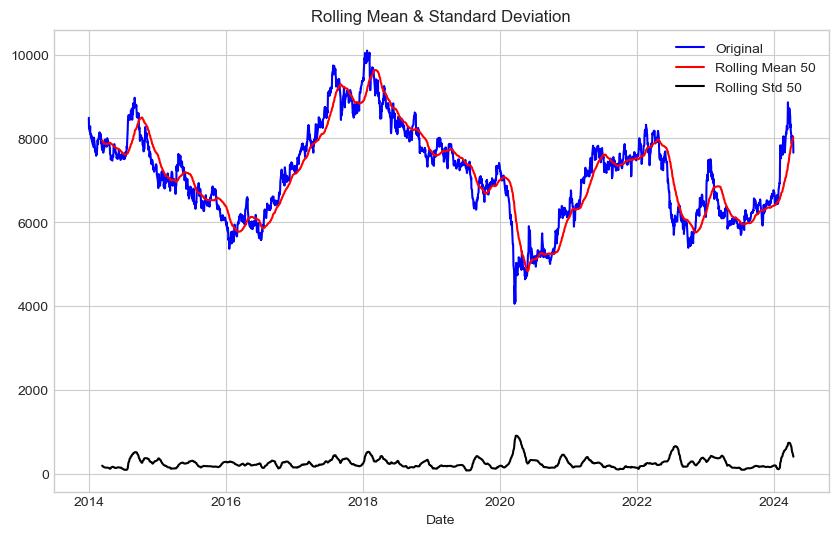

In [255]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean {}'.format(interval))
    std = plt.plot(rolstd, color='black', label = 'Rolling Std {}'.format(interval))
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

# 50일치 평균내어 이동평균계산
plot_rolling(data, 50)

- 해석1. 데이터가 평균이 일정하지 않은 비정상성의 특징(아래 개념 설명)을 가지는 것 같아 보이므로, 변환과정을 거친다면 ARIMA의 d차수(아래 개념 설명)가 1 이상일 것이다.  
- 해석2. 계절성이나 특정 주기성은 크게 확인되지 않기 때문에 추후 ARIMA 분석에서 모수 seasonal이나 m은 auto_arima에 적용할 필요가 없을 수도 있다.  

1) 원본데이터 ADF 테스트

In [180]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    result = adfuller(data.values)
    print('ADF Statistics: %f' % result[0])
    print('p-value: %f' % result[1])
    print('num of lags: %f' % result[2])
    print('num of observations: %f' % result[3])
    print('Critical values:')
    for k, v in result[4].items():
        print('\t%s: %.3f' % (k,v))

print('ADF TEST 결과')
adf_test(data)

ADF TEST 결과
ADF Statistics: -2.514595
p-value: 0.111963
num of lags: 0.000000
num of observations: 2528.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


해석>
pvalue > 0.05 이므로 귀무가설을 기각할 수 없다. 따라서 KODEX은행 데이터 (data) 는 비정상성 데이터이다.

2) 차분 데이터 ADF 테스트

<Axes: xlabel='날짜'>

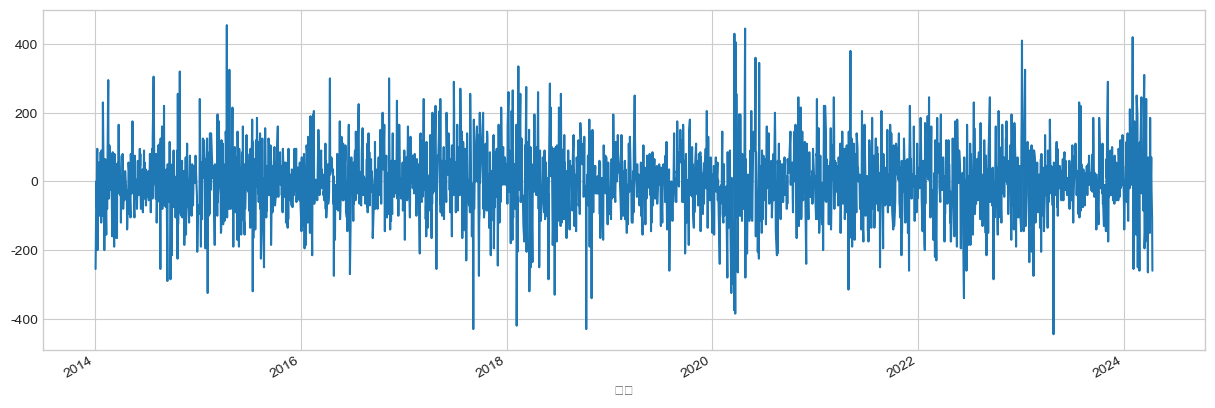

In [181]:
# 1차 차분 데이터 diff1
dff1 = data.diff().dropna()
dff1.plot(figsize=(15,5))

In [182]:
# 차분 테이터 adf테스트
print('ADF TEST 결과')
adf_test(dff1)

ADF TEST 결과
ADF Statistics: -50.806472
p-value: 0.000000
num of lags: 0.000000
num of observations: 2527.000000
Critical values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


해석> pvalue가 0.05미만이므로 가설 기각(채택), 1차 차분 처리한 데이터가 정상성 데이터가 되었다!
=> 비정상성 데이터는 차분을 이용하여 안정적으로 만들어 분석한다. (ARIMA)

결론 : 원본데이터는 비정상성 시계열 데이터이므로 차분을 이용하는 시계열 모형을 사용하자! = ARIMA를 사용하자

2. ARIMA(p,d,q) 모수 추정

AR(p), 차분(d), MA(q)에서 보통 p+q <2, p*q=0 인 값을 많이 사용한다. (p,q둘 중 한 값이 0)
실제로는 AR 이나 MA 둘중 하나의 경향을 강하게 띄기 때문에 주로 이렇게 사용한다.  

추정 방법은 (방법1)ACF plot과 PACF plot을 통해 모수 추정 하는 것과 (방법2)pmdarima 라이브러리의 ndiffs, auto_arima 함수를 사용하여 모수 추정하는 방법이 있다.  

ACF plot 과 PACF plot 은 현재 값이 과거 값과 어떤 relationship이 있는지 보여준다.

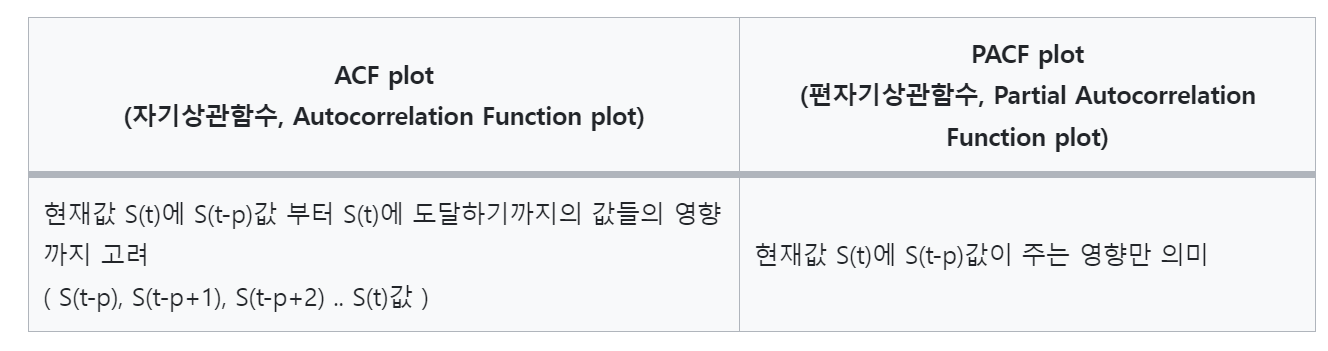

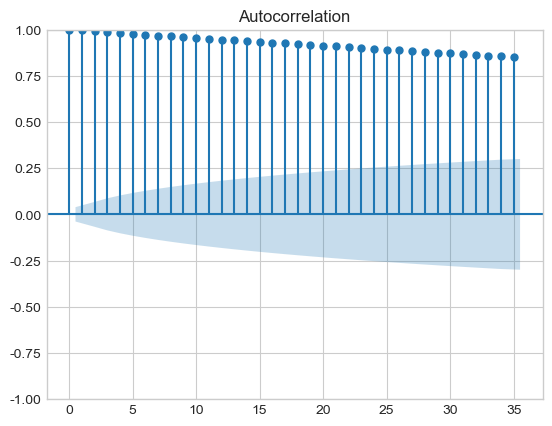

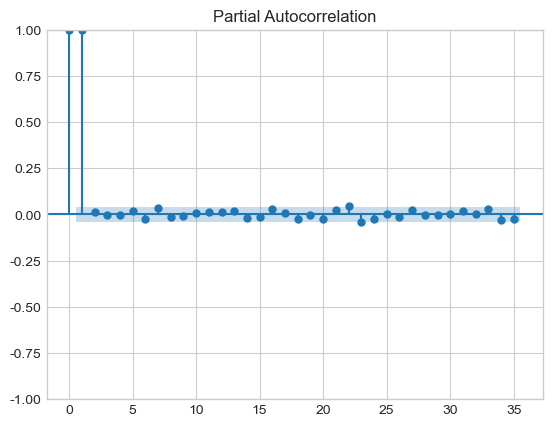

In [183]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data)
plot_pacf(data)
plt.show()

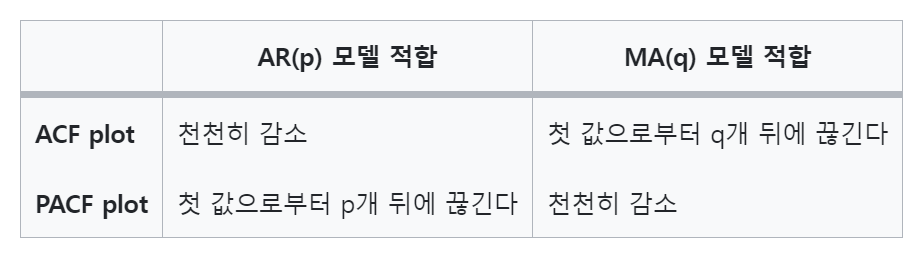

해석> ACF plot가 천천히 감소되는 것으로 보아 은행주 지수 데이터는 주기에 따라 일정하지 않은 비정상성 데이터이고,  
PACF plot에서 첫값으로부터 1개 이후 파란 박스에 들어가면서 그래프가 끊기는 것으로 보아 AR(1) 모델을 활용하는 것이 가장 적절할 것으로 예상된다


1차 차분 데이터 (정상성) > ACF 그래프 1개 뒤에 끊김

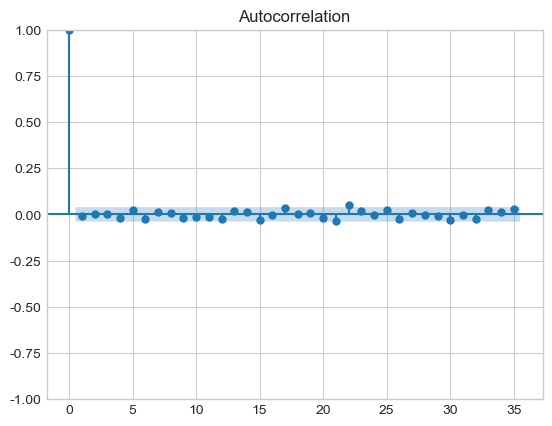

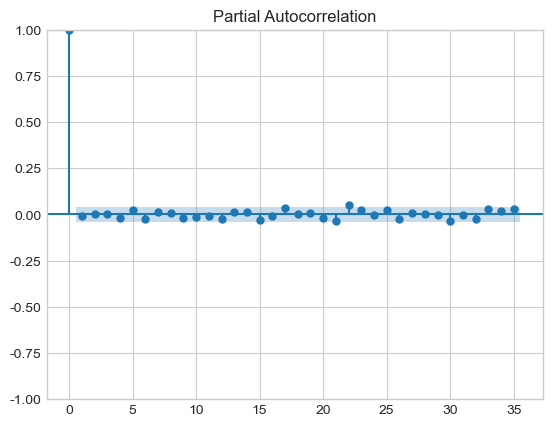

In [184]:
plot_acf(dff1)
plot_pacf(dff1)
plt.show()

- 빠른 다른 방법 -> 라이브러리 사용
https://velog.io/@dankj1991/time-series-3-ARIMA

In [211]:
#데이터 나누기
# train : test = 9 : 1
train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

In [218]:
import pmdarima as pm
from pmdarima.arima import ndiffs
data = merged_df['종가']

kpss_diffs = pm.arima.ndiffs(train_data, alpha=0.05, test='kpss', max_d=5)
adf_diffs = pm.arima.ndiffs(train_data, alpha=0.05, test='adf', max_d=5)
n_diffs = max(kpss_diffs, adf_diffs)


print(f"추정된 차수 d = {n_diffs}") # 결과
#추정된 차수 d = 1
# 1차 차분만으로도 정상성을 만족할 수 있으므로 d값은 1로 설정

추정된 차수 d = 1


In [219]:
model = pm.auto_arima(
            y=train_data, 
            d=n_diffs, 
            start_p=0, max_p=5, 
            start_q=0, max_q=5, 
            m=1, seasonal=False, # 계절성이 없음!
            stepwise=True,
            trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27489.137, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27490.185, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27490.218, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27487.355, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=27491.898, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.643 seconds


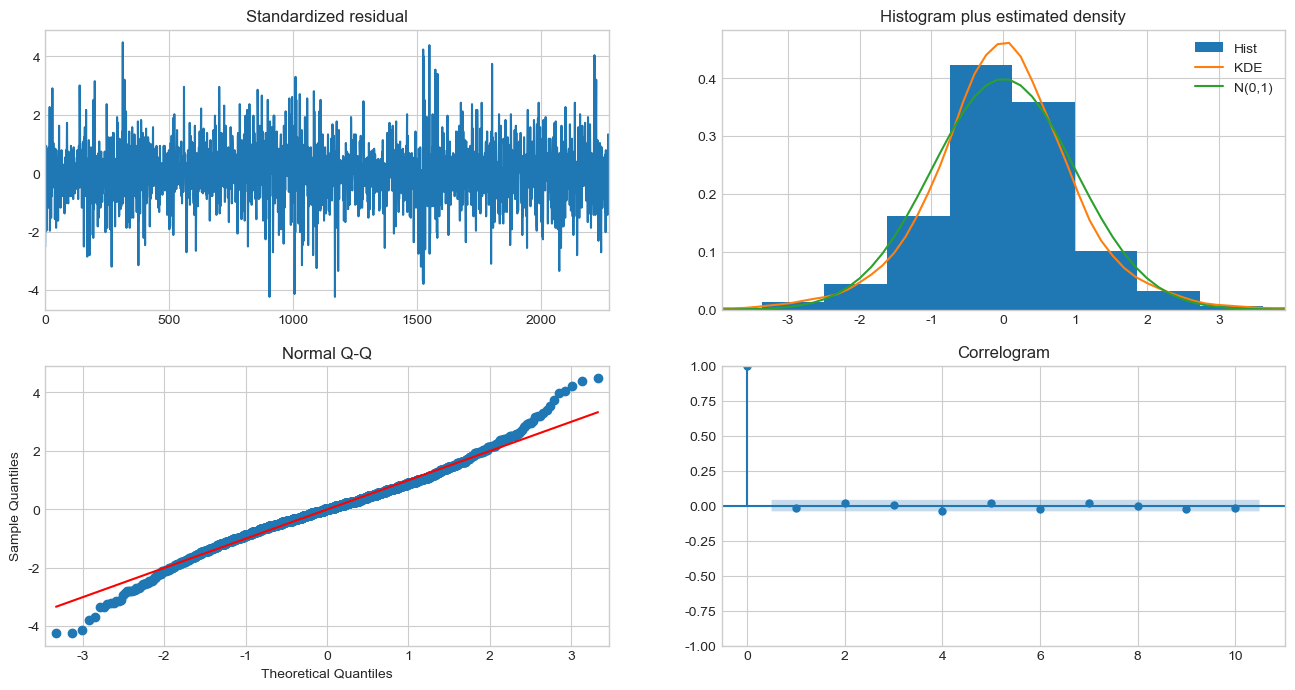

In [220]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

결론: ACF, PACF 그래프 그려본 결과, AR(1), d(1), MA(0)이 적절해 보인다

ARIMA모델 훈련과 테스트

훈련에는 적용되지 않은 테스트데이터를 통해 예측을 실시해봅니다

In [185]:
##이미나눠져있음
# # 1) train, test set분리

# # train : test = 9 : 1
# train_data, test_data = data[:int(len(data)*0.9)], data[int(len(data)*0.9):]

In [269]:
train_data.shape

(2276,)

In [267]:
test_data.shape

(253,)

한번에 예측을 진행해봅니다 (트렌드만을 고려한 예측이 실시됩니다)

In [ ]:
# 예측 -> 리스트로 변환
pred = model.predict(n_periods=len(test_data)).to_list()
# 데이터프레임 생성
test_pred = pd.DataFrame({'test':test_data, 'pred':pred}, index=test_data.index)
test_pred

In [216]:
test_pred.iloc[110] #전부 7660???

test    6295.0
pred    6225.0
Name: 2023-09-11 00:00:00, dtype: float64

시각화로 확인해보기

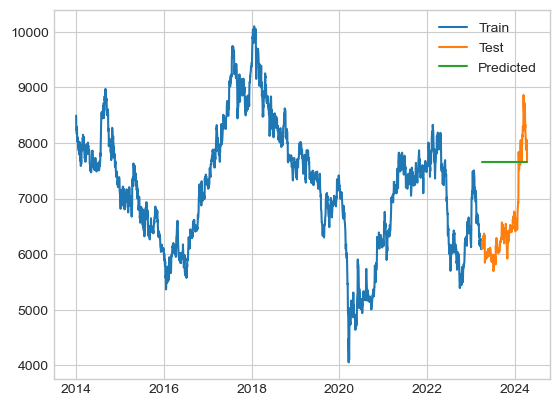

In [209]:
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred.pred, label='Predicted')
plt.legend()
plt.show()
#?????????????????

이번에는 한 지점에 대한 예측을 진행하고 모델을 업데이트 하는 방식으로 예측을 진행해보도록 하겠습니다. (트렌드 이외에도 변동요인들이 모두 반영됩니다)

In [223]:
# one point forcast 함수 정의, 신뢰구간도 함께 담아보기
def forcast_one_step():
    fc, conf = model.predict(n_periods=1, return_conf_int=True)
    return fc.tolist()[0], np.asarray(conf).tolist()[0]

# 값들을 담을 빈 리스트를 생성
y_pred = []
pred_upper = []
pred_lower = []

# for문을 통한 예측 및 모델 업데이트를 반복함
for new_ob in test_data:
    fc, conf = forcast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])
    model.update(new_ob)

In [224]:
test_pred = pd.DataFrame({'test':test_data, 'pred':y_pred})
y_pred_df = test_pred['pred']	# Series로 반환
y_pred_df

날짜
2023-04-03    6225.0
2023-04-04    6185.0
2023-04-05    6220.0
2023-04-06    6230.0
2023-04-07    6095.0
               ...  
2024-04-05    8060.0
2024-04-08    7985.0
2024-04-09    8055.0
2024-04-11    8030.0
2024-04-12    7920.0
Name: pred, Length: 253, dtype: float64

시각화로 확인

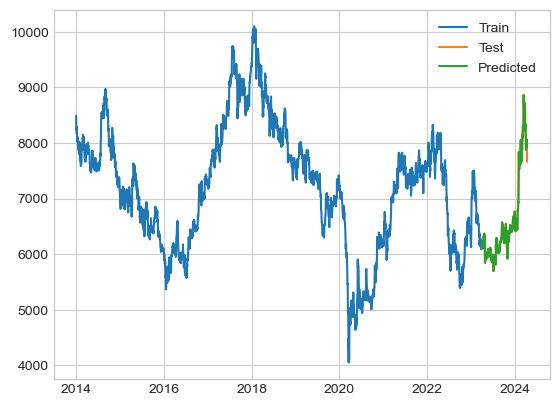

In [225]:
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_pred_df, label='Predicted')
plt.legend()
plt.show()

업데이트된 모델 분석

In [226]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2529
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -15272.846
Date:                Sun, 14 Apr 2024   AIC                          30547.691
Time:                        16:34:34   BIC                          30553.526
Sample:                             0   HQIC                         30549.809
                               - 2529                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.035e+04    212.509     48.720      0.000    9936.894    1.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):               325.72
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                             0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

예측 모델 오차 계산 (MAPE)

In [227]:
# sklearn으로 MAPE 계산
from sklearn.metrics import mean_absolute_percentage_error
print(f"MAPE : {mean_absolute_percentage_error(test_data, y_pred):.3f}")
#MAPE : 0.011

MAPE : 0.011


In [230]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(f"MSE : {mean_squared_error(test_data, y_pred):.3f}")

MSE : 10490.415


In [ ]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import math
# mse = mean_squared_error(np.exp(test_data), np.exp(fc))
# print('MSE: ', mse)
# mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
# print('MAE: ', mae)
# rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
# print('RMSE: ', rmse)
# mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
# print('MAPE: ' ,'{:.2f}%'.format(mape*100))

# 이거아닌듯

In [166]:
# pip install pmdarima
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

C:\Users\chanyoung\AppData\Local\Temp\ipykernel_19680\787373296.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


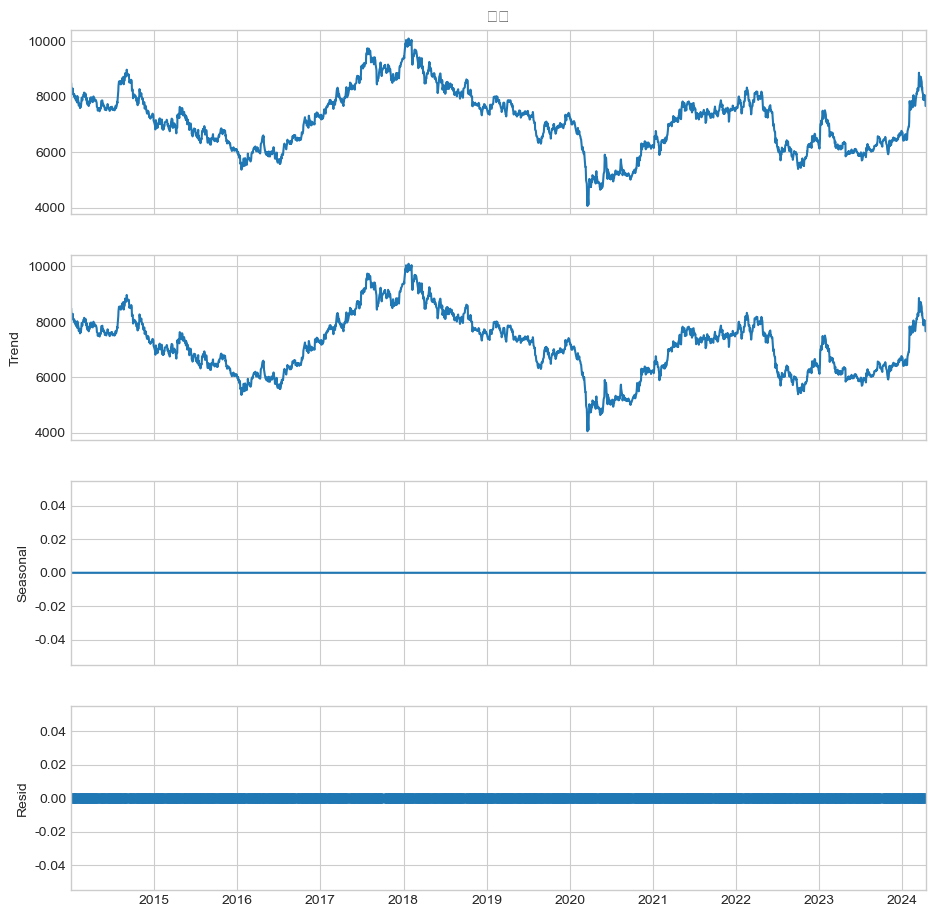

In [167]:
# decompostion이란, 시계열 데이터를 시계열 4요소(추세, 순환, 계절, 불규칙)으로 분해하는 기법
# seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(merged_df['종가'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

### 이동평균선 추가

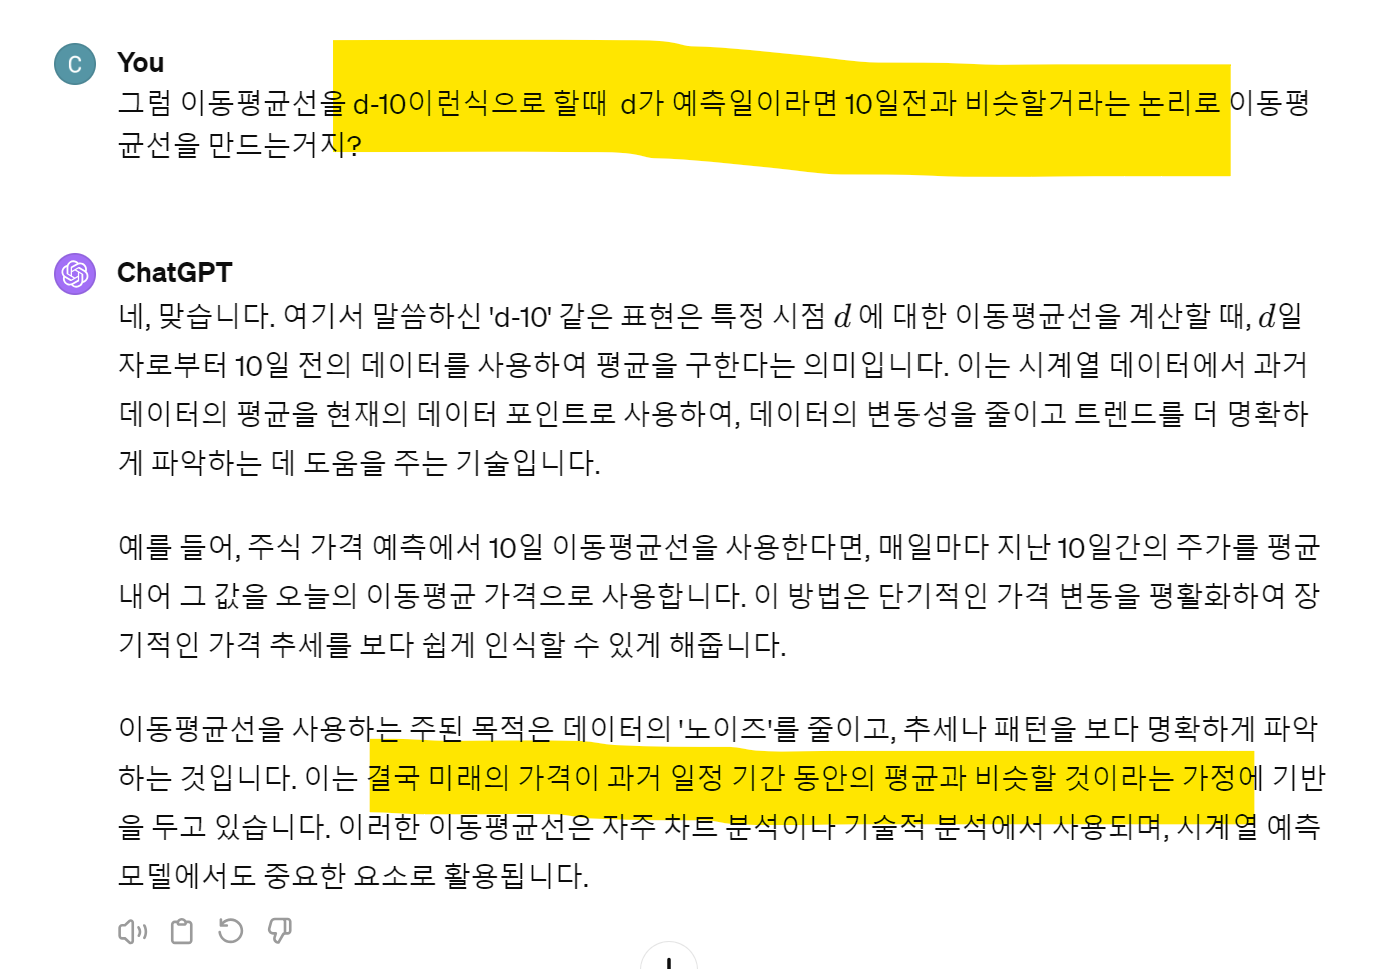

In [105]:
#라이브러리 호출
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [106]:
# merged_df = merged_df.drop(columns=['moving_average_3'])
# merged_df

,시가,고가,저가,종가,거래량,log_return,target
날짜,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1
...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0


In [240]:
# # 5일 이동평균 추가
merged_df['moving_average_5'] = merged_df['종가'].rolling(window=5).mean().shift(1)  # 이동평균을 계산하고 한 스텝 쉬프트
merged_df

,시가,고가,저가,종가,거래량,log_return,target,moving_average_3,moving_average_10,moving_average_30,moving_average_60,moving_average_120,moving_average_240,moving_average_5
날짜,,,,,,,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,8320.000000,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,8210.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,7986.666667,8262.5,8236.166667,7675.500000,7043.416667,6568.604167,8041.0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,7973.333333,8190.5,8241.833333,7700.833333,7056.083333,6576.270833,8000.0
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8033.333333,8137.5,8246.166667,7727.583333,7069.416667,6583.479167,8000.0


In [233]:
#10일선
merged_df['moving_average_10'] = merged_df['종가'].rolling(window=10).mean().shift(1)  # 이동평균을 계산하고 한 스텝 쉬프트
merged_df

,시가,고가,저가,종가,거래량,log_return,target,moving_average_3,moving_average_10
날짜,,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,8320.000000,NaN
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,8210.000000,NaN
...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,7986.666667,8262.5
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,7973.333333,8190.5
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8033.333333,8137.5


In [234]:
#30일선
merged_df['moving_average_30'] = merged_df['종가'].rolling(window=30).mean().shift(1)  # 이동평균을 계산하고 한 스텝 쉬프트
merged_df

,시가,고가,저가,종가,거래량,log_return,target,moving_average_3,moving_average_10,moving_average_30
날짜,,,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN,NaN,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN,NaN,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN,NaN,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,8320.000000,NaN,NaN
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,8210.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,7986.666667,8262.5,8236.166667
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,7973.333333,8190.5,8241.833333
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8033.333333,8137.5,8246.166667


In [235]:
#60일선
merged_df['moving_average_60'] = merged_df['종가'].rolling(window=60).mean().shift(1)  # 이동평균을 계산하고 한 스텝 쉬프트
merged_df

,시가,고가,저가,종가,거래량,log_return,target,moving_average_3,moving_average_10,moving_average_30,moving_average_60
날짜,,,,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN,NaN,NaN,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN,NaN,NaN,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN,NaN,NaN,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,8320.000000,NaN,NaN,NaN
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,8210.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,7986.666667,8262.5,8236.166667,7675.500000
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,7973.333333,8190.5,8241.833333,7700.833333
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8033.333333,8137.5,8246.166667,7727.583333


In [236]:
#120일선 #장기 이동평균선
merged_df['moving_average_120'] = merged_df['종가'].rolling(window=120).mean().shift(1)  # 이동평균을 계산하고 한 스텝 쉬프트
merged_df

,시가,고가,저가,종가,거래량,log_return,target,moving_average_3,moving_average_10,moving_average_30,moving_average_60,moving_average_120
날짜,,,,,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN,NaN,NaN,NaN,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN,NaN,NaN,NaN,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN,NaN,NaN,NaN,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,8320.000000,NaN,NaN,NaN,NaN
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,8210.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,7986.666667,8262.5,8236.166667,7675.500000,7043.416667
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,7973.333333,8190.5,8241.833333,7700.833333,7056.083333
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8033.333333,8137.5,8246.166667,7727.583333,7069.416667


In [237]:
#240일선 #장기 이동평균선
merged_df['moving_average_240'] = merged_df['종가'].rolling(window=240).mean().shift(1)  # 이동평균을 계산하고 한 스텝 쉬프트
merged_df

,시가,고가,저가,종가,거래량,log_return,target,moving_average_3,moving_average_10,moving_average_30,moving_average_60,moving_average_120,moving_average_240
날짜,,,,,,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,8320.000000,NaN,NaN,NaN,NaN,NaN
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,8210.000000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,7986.666667,8262.5,8236.166667,7675.500000,7043.416667,6568.604167
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,7973.333333,8190.5,8241.833333,7700.833333,7056.083333,6576.270833
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8033.333333,8137.5,8246.166667,7727.583333,7069.416667,6583.479167


In [246]:
merged_df.rename(columns={'시가':'Open','고가':'High','저가':'Low','종가':'Close','거래량':'Volume'},inplace= True)
merged_df

,Open,High,Low,Close,Volume,log_return,target,moving_average_3,moving_average_10,moving_average_30,moving_average_60,moving_average_120,moving_average_240,moving_average_5
날짜,,,,,,,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,8320.000000,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,8210.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,7986.666667,8262.5,8236.166667,7675.500000,7043.416667,6568.604167,8041.0
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,7973.333333,8190.5,8241.833333,7700.833333,7056.083333,6576.270833,8000.0
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8033.333333,8137.5,8246.166667,7727.583333,7069.416667,6583.479167,8000.0


In [249]:
merged_df.drop('moving_average_3',axis=1,inplace=True)

In [250]:
merged_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'log_return', 'target',
       'moving_average_10', 'moving_average_30', 'moving_average_60',
       'moving_average_120', 'moving_average_240', 'moving_average_5'],
      dtype='object')

In [251]:
merged_df = merged_df[['Open', 'High', 'Low', 'Close', 'Volume', 'log_return', 'target','moving_average_5',
       'moving_average_10', 'moving_average_30', 'moving_average_60',
       'moving_average_120', 'moving_average_240']]
merged_df

,Open,High,Low,Close,Volume,log_return,target,moving_average_5,moving_average_10,moving_average_30,moving_average_60,moving_average_120,moving_average_240
날짜,,,,,,,,,,,,,
2014-01-02,8595.0,8680.0,8410.0,8490.0,118777.0,-0.005872,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,8425.0,8435.0,8220.0,8235.0,16046.0,-0.030496,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,8255.0,8325.0,8160.0,8235.0,5639.0,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,8200.0,8260.0,8160.0,8160.0,11565.0,-0.009149,0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,8190.0,8260.0,8135.0,8195.0,7145.0,0.004280,1,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,8041.0,8262.5,8236.166667,7675.500000,7043.416667,6568.604167
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,8000.0,8190.5,8241.833333,7700.833333,7056.083333,6576.270833
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8000.0,8137.5,8246.166667,7727.583333,7069.416667,6583.479167


In [256]:
# 이동 평균선이 NaN인 행 제거
merged_df_ma = merged_df.dropna(inplace=True)
merged_df_ma

In [258]:
merged_df

,Open,High,Low,Close,Volume,log_return,target,moving_average_5,moving_average_10,moving_average_30,moving_average_60,moving_average_120,moving_average_240
날짜,,,,,,,,,,,,,
2014-12-23,7290.0,7290.0,7250.0,7290.0,2424.0,0.002060,1,7252.0,7275.5,7511.166667,7756.750000,8018.000000,7917.687500
2014-12-24,7300.0,7365.0,7265.0,7365.0,21753.0,0.010236,1,7269.0,7264.5,7491.000000,7741.333333,8015.125000,7912.687500
2014-12-26,7400.0,7420.0,7360.0,7385.0,7384.0,0.002712,1,7292.0,7271.0,7472.333333,7726.416667,8013.458333,7909.062500
2014-12-29,7465.0,7465.0,7320.0,7340.0,10208.0,-0.006112,0,7319.0,7284.0,7454.666667,7713.583333,8011.916667,7905.520833
2014-12-30,7375.0,7375.0,7110.0,7135.0,30329.0,-0.028327,0,7331.0,7287.5,7441.666667,7703.583333,8010.083333,7902.104167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-05,7950.0,8075.0,7935.0,7985.0,393780.0,-0.009349,0,8041.0,8262.5,8236.166667,7675.500000,7043.416667,6568.604167
2024-04-08,8000.0,8130.0,7980.0,8055.0,748528.0,0.008728,1,8000.0,8190.5,8241.833333,7700.833333,7056.083333,6576.270833
2024-04-09,8085.0,8140.0,7985.0,8030.0,423717.0,-0.003108,0,8000.0,8137.5,8246.166667,7727.583333,7069.416667,6583.479167


In [261]:
merged_df.to_csv("data_for_bank.csv")

### 상관관계를 구한 결과
- 종가,시가,고가,저가와 각가그이 이동평균선들은 서로 아주 높은 양의 상관관계를 보임을 확인할 수 있었음
정비례한다고 볼수 잇음
- 지수를 예측하는데에 각각의 이동평균선이 관계가 있다고 볼 수 있다.

https://nyamin9-data.tistory.com/12

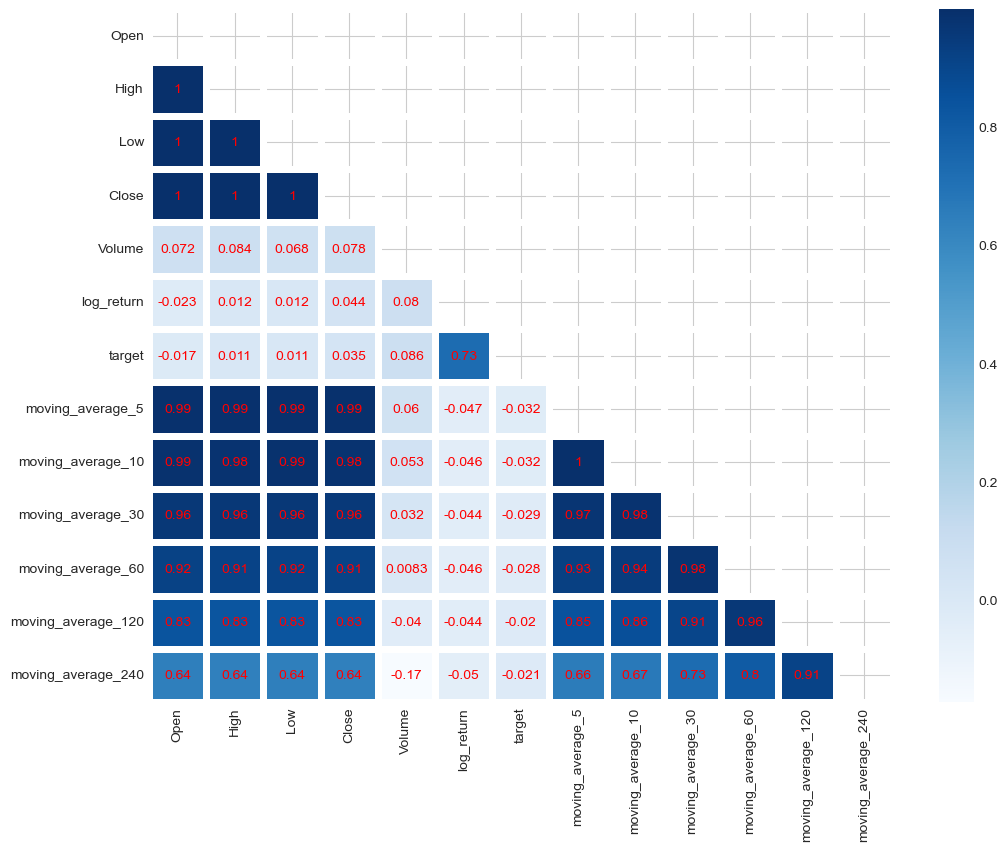

In [252]:
kodex_corr = merged_df.corr()
mask = np.zeros_like(kodex_corr,dtype=np.bool_)
mask[np.triu_indices_from(mask)] =True

plt.figure(figsize=(12,9))
ax = sns.heatmap(kodex_corr,mask = mask, annot= True,annot_kws=dict(color='r'),linewidths=5,cmap='Blues')
plt.show()

### 시계열 데이터에서 train, validation, test 나누기
-> 보통회귀와는 다름

!조심하기!  

시계열 데이터는 window size만큼 들어가도록 input을 설계하는데, 이때 w사이즈 만큼의 input data가 train set 전체에 대해서 min-max 스케일링이 된 상태라면, 미래 시점의 데이터까지 같이 고려하여 스케일링이 되기 때문입니다. (절대 알 수 없는 미래 데이터가 개입 됨) trainset은 그렇다쳐도, 적어도!! testset에 대해서는 trainset에서 스케일링했던 통계 값으로 스케일링을 해주었어야 합니다. 
예전에 제가 주식 데이터를 다룰 때, 위 저자처럼 min-max 스케일링을 진행했다가 나중에 잘못됨을 느끼고, 생각보다 시계열 데이터에 대한 스케일링은 섬세해야 함을 깨달아 문제를 정의하게 되었고, 그것에 대해 실험하여 논문을 쓰게 되었습니다. 실험한 논문에 대한 글의 링크를 첨부합니다. 

https://inhovation97.tistory.com/71

In [120]:
# # 데이터 시간 순서대로 분할 ->그냥 train test val 로 나누면 시계열의 특성이 무시됨!!

# # 데이터의 70%, 15%, 15%로 분할하기
# n = len(merged_df)
# train_df = merged_df.iloc[:int(n*0.7)]
# val_df = merged_df.iloc[int(n*0.7):int(n*0.85)]
# test_df = merged_df.iloc[int(n*0.85):]

In [168]:
# 데이터셋 분할 ->shuffle=False를 줘야함! 그래야 밑둥부터
X = merged_df.drop(columns=["target"])
y = merged_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

시계열 데이터의 예측을 위해서는 데이터가 stationary인지, non-stationary인지 확인하는 절차를 거쳐야 한다.

따라서 ACF, PACF 플롯을 시각화하여 stationary 여부를 확인하고, non-stationary 일 경우 차분(difference)을 진행

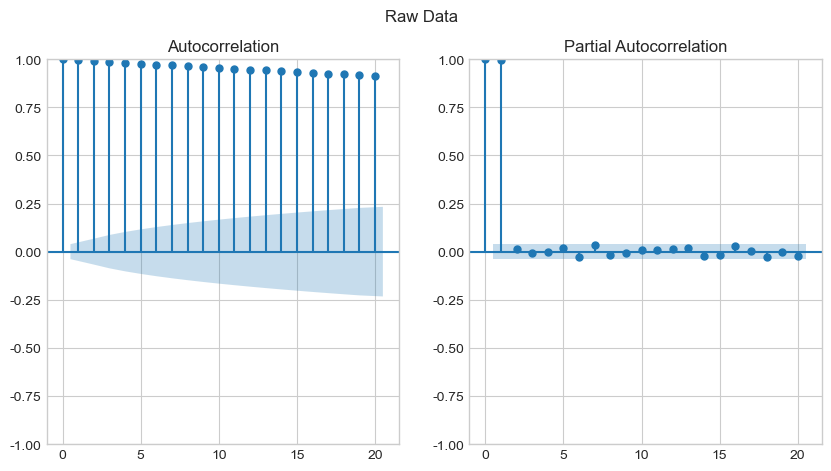

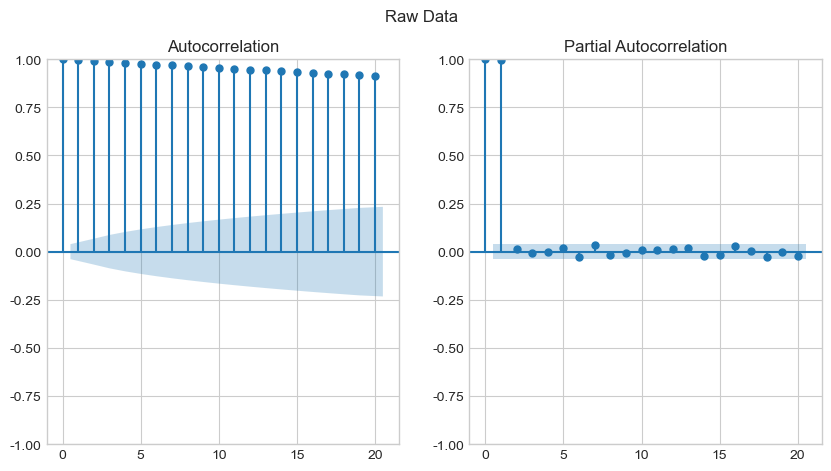

In [177]:
#자기상관함수(ACF), 편자기상관함수(PACF)
# ACF, PACF plot
# PACF는 correlation을 측정하는 것은 ACF와 동일하나, t와 t+k 사이에 다른 값들의 영향력을 배제하고 측정하는 것

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(merged_df['종가'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(merged_df['종가'].values.squeeze(), lags=20, ax=ax[1])
#`tsa.plot_pacf` is a function from the Statsmodels library that is used to plot the partial autocorrelation function (PACF) of a time series data. The PACF shows the correlation between a time series and its lagged values, while taking into account the correlations with the intermediate lags. It helps in identifying the direct relationship between the current value of a time series and its lagged values, after removing the effects of the intermediate time points.


In [122]:
# 모델 정의
ar_model = AutoReg(y_train, lags=1)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gbm_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

c:\Users\chanyoung\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [123]:
# AR(p) 모델 학습
ar_model_fitted = ar_model.fit()

In [124]:
# 앙상블 모델 학습
rf_model.fit(X_train, y_train)
gbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [125]:
# 예측 및 성능 평가
y_pred_ar = ar_model_fitted.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
y_pred_rf = rf_model.predict(X_test)
y_pred_gbm = gbm_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

c:\Users\chanyoung\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chanyoung\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\chanyoung\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [162]:
# 성능 메트릭 계산
metrics = {
    "AR(p)": {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_ar)),
        "MAE": mean_absolute_error(y_test, y_pred_ar)
    },
    "Random Forest": {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        "MAE": mean_absolute_error(y_test, y_pred_rf)
    },
    "GBM": {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_gbm)),
        "MAE": mean_absolute_error(y_test, y_pred_gbm)
    },
    "XGBoost": {
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb)),
        "MAE": mean_absolute_error(y_test, y_pred_xgb)
    }
}

metrics
#변수 

{'AR(p)': {'RMSE': 0.4998938677036908, 'MAE': 0.49964380262201735},
 'Random Forest': {'RMSE': 0.0, 'MAE': 0.0},
 'GBM': {'RMSE': 1.3279121528522822e-05, 'MAE': 1.327226633116791e-05},
 'XGBoost': {'RMSE': 1.6225581989851685e-05, 'MAE': 1.621720580781696e-05}}

# 모델링

In [259]:
# 특성과 타겟 분리
X = merged_df.drop('target', axis=1)
y = merged_df['target']

In [ ]:
# 데이터를 학습 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3일 이동평균 추가

### 차분진행
-https://assaeunji.github.io/statistics/2021-08-08-stationarity/

- 시사점

은행주 PBR, 적정선은 어디쯤
강지수 기자2022.10.13 08:09:44가가
'고평가' 카카오뱅크와 '저평가' 은행주 사이, 접점 찾기가 과제
https://dealsite.co.kr/articles/92993